--- Démarrage de la génération des masques guides ---
Nombre d'images trouvées : 144
Traitement : 20/144 images...
Traitement : 40/144 images...
Traitement : 60/144 images...
Traitement : 100/144 images...
Traitement : 120/144 images...
Traitement : 140/144 images...
Terminé. 135 images utilisées.
Fichier numpy sauvegardé dans : ./Results/GuideMasks/


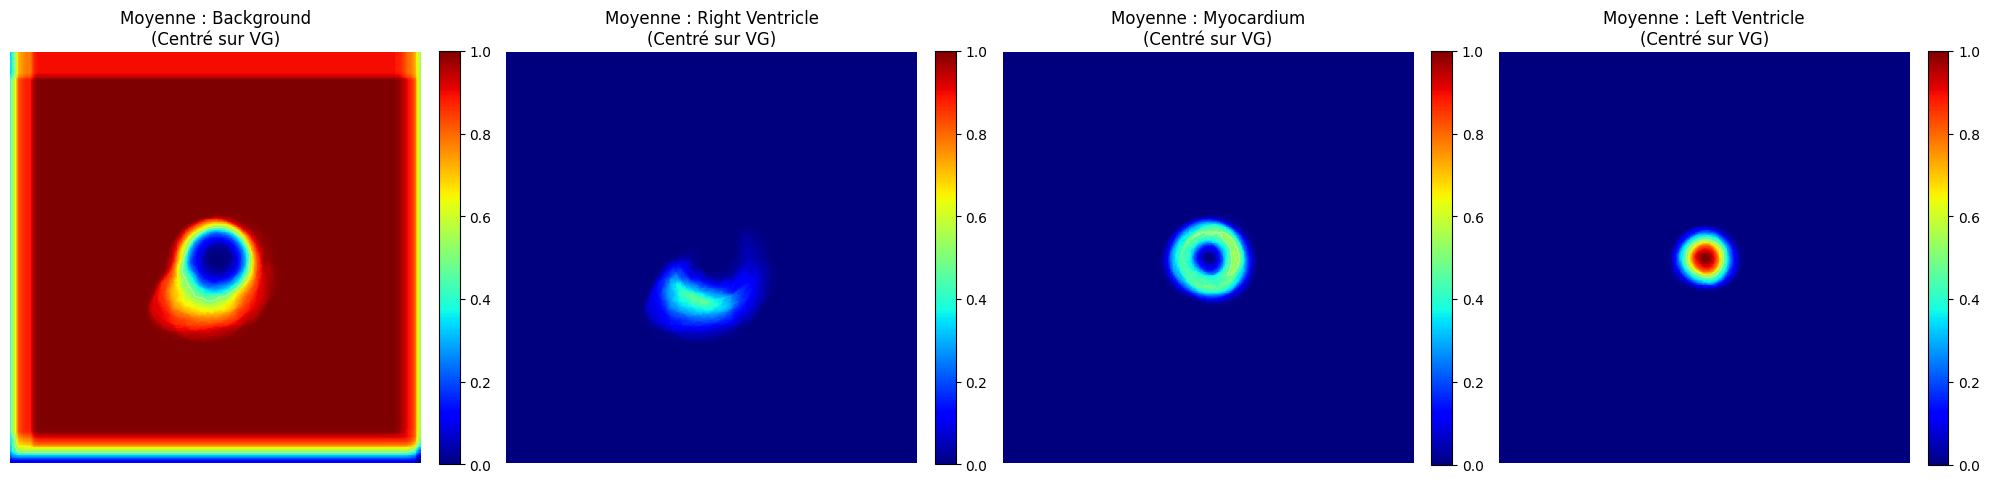

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
from scipy.ndimage import center_of_mass, shift
import os

import medicalDataLoader
from utils import getTargetSegmentation

ROOT_DIR = './Data/'
NUM_CLASSES = 4
IMG_SIZE = 256  
LV_CLASS_INDEX = 3  
SAVE_DIR = './Results/GuideMasks/'

def generate_guide_masks():
    """
    Génère masques guides centré sur le ventricule gauche.
    
    Parcourt tout le dataset train, aligne chaque masque pour que le VG
    soit au centre de l'image, et calcule la probabilité moyenne d'apparition
    de chaque classe à chaque position
    """
    print("Démarrage de la génération des masques guides")
    
    #transformation minimes, conversion en Tensor
    transform = transforms.Compose([transforms.ToTensor()])
    mask_transform = transforms.Compose([transforms.ToTensor()])

    train_set = medicalDataLoader.MedicalImageDataset(
        'train', 
        ROOT_DIR, 
        transform=transform, 
        mask_transform=mask_transform, 
        augment=False, #pas d'augmentation
        equalize=False #intensités d'origine 
    )
    
    #batch de size 1 car images traitées une à une
    loader = DataLoader(train_set, batch_size=1, shuffle=False, num_workers=0)

    #tableau vide 
    accumulated_masks = np.zeros((NUM_CLASSES, IMG_SIZE, IMG_SIZE), dtype=np.float32)
    count_valid_images = 0#compteur des images qui ont un VG

    print(f"Nombre d'images qui ont un VG : {len(loader)}")

    for i, data in enumerate(loader):
        # on garde que les labels
        _, labels, _ = data
        
        # Conversion du label en classes 
        gt_mask = getTargetSegmentation(labels).numpy()
        
        #masque binaire 1 = VG, 0 = ailleurs
        lv_mask = (gt_mask == LV_CLASS_INDEX).astype(int)
        
        if lv_mask.sum() == 0:
            continue
            
        # Calcul du barycentre (y, x) du masque binaire du VG
        center_y, center_x = center_of_mass(lv_mask)
        
        #vecteur de translation
        target_center = IMG_SIZE // 2
        shift_y = target_center - center_y
        shift_x = target_center - center_x
        

        for c in range(NUM_CLASSES):
            # masque binaire pour la classe courante
            class_mask = (gt_mask == c).astype(np.float32)
            
            # Appliquer la translation
            shifted_mask = shift(class_mask, shift=[shift_y, shift_x], order=0, cval=0.0)
            
            accumulated_masks[c] += shifted_mask

        count_valid_images += 1
        
        if (i+1) % 20 == 0:
            print(f"Traitement : {i+1}/{len(loader)} images...")


    # Le résultat est une map de probabilité entre 0 et 1 pour chaque pixel
    if count_valid_images > 0:
        guide_masks = accumulated_masks / count_valid_images
    else:
        print("Erreur : Aucune image valide avec un VG")
        return

    print(f"Terminé. {count_valid_images} images utilisées.")

    if not os.path.exists(SAVE_DIR):
        os.makedirs(SAVE_DIR)

    np.save(os.path.join(SAVE_DIR, 'guide_masks_centered_LV.npy'), guide_masks)
    print(f"Fichier numpy sauvegardé dans : {SAVE_DIR}")

    # Affichage
    visualize_guides(guide_masks)

def visualize_guides(guide_masks):
    """
    Affiche les cartes de probabilité pour chaque classe.
    Rouge = Haute probabilité, Bleu = Faible probabilité.
    """
    class_names = ["Background", "Right Ventricle", "Myocardium", "Left Ventricle"]
    
    plt.figure(figsize=(20, 5))
    
    for c in range(NUM_CLASSES):
        plt.subplot(1, 4, c+1)

        #  affichage de la heatmap 
        plt.imshow(guide_masks[c], cmap='jet', vmin=0, vmax=1)
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.title(f"Moyenne : {class_names[c]}\n(Centré sur VG)")
        plt.axis('off')
        
        # Ajout d'un contour pour voir la forme moyenne 
        plt.contour(guide_masks[c], levels=[0.5], colors='white', linewidths=0.5, alpha=0.5)

    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, 'visualisation_guides.png'))
    plt.show()

if __name__ == "__main__":
    generate_guide_masks()

--- Application du flou Gaussien (Sigma=5) ---
Guides chargés. Shape : (4, 256, 256)
Guides floutés sauvegardés sous : ./Results/GuideMasks/guide_masks_probabilistic.npy


<Figure size 1200x600 with 0 Axes>

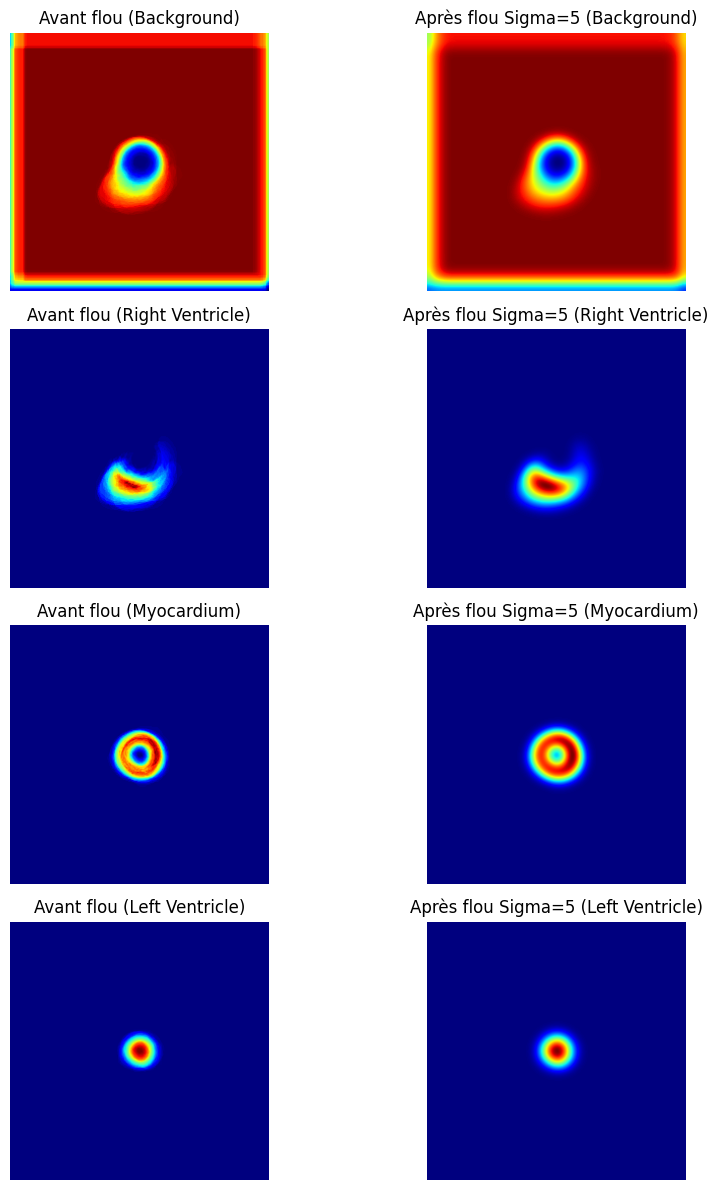

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

LOAD_PATH = './Results/GuideMasks/guide_masks_centered_LV.npy'
SAVE_PATH = './Results/GuideMasks/guide_masks_probabilistic.npy'
SIGMA = 5  
NUM_CLASSES = 4

def apply_gaussian_blur_to_guides():
    """
    Transforme les masques moyens en cartes de probabilité douces

    """
    print(f"Application du flou Gaussien (Sigma={SIGMA})")
    
    if not os.path.exists(LOAD_PATH):
        print(f"Erreur : Le fichier {LOAD_PATH} n'existe pas. Lancez la génération précédente d'abord.")
        return

    # chargement du masque guide net
    guides = np.load(LOAD_PATH)
    print(f"Guides chargés. Shape : {guides.shape}")

    # application du flou, tableau vide de la même taille
    guides_blurred = np.zeros_like(guides)
    
    for c in range(NUM_CLASSES):
        current_sigma = SIGMA if c > 0 else SIGMA
        
        #appliquer convolution avec noyau gaussien
        guides_blurred[c] = gaussian_filter(guides[c], sigma=current_sigma)
        
        # Normalisation, on met le max à 1 pour aider le réseau
        max_val = guides_blurred[c].max()
        if max_val > 0:
            guides_blurred[c] /= max_val


    np.save(SAVE_PATH, guides_blurred.astype(np.float32))
    print(f"Guides floutés sauvegardés sous : {SAVE_PATH}")

    # visualisation 
    class_names = ["Background", "Right Ventricle", "Myocardium", "Left Ventricle"]
    plt.figure(figsize=(12, 6))
    
    # On affiche seulement le VG =classe 3 pour comparer avant/après
    c = 3 
    
    plt.figure(figsize=(10, 12))

    for c in range(4):
        # Avant flou
        plt.subplot(4, 2, 2*c + 1)
        plt.imshow(guides[c], cmap="jet")
        plt.title(f"Avant flou ({class_names[c]})")
        plt.axis("off")
        
        # Après flou
        plt.subplot(4, 2, 2*c + 2)
        plt.imshow(guides_blurred[c], cmap="jet")
        plt.title(f"Après flou Sigma={SIGMA} ({class_names[c]})")
        plt.axis("off")

    plt.tight_layout()
    plt.show()
if __name__ == "__main__":
    apply_gaussian_blur_to_guides()

--- Entraînement du ComplexHeartLocator ---
Epoch 0 [Train][=>             ] 11.1%Loss=0.02336

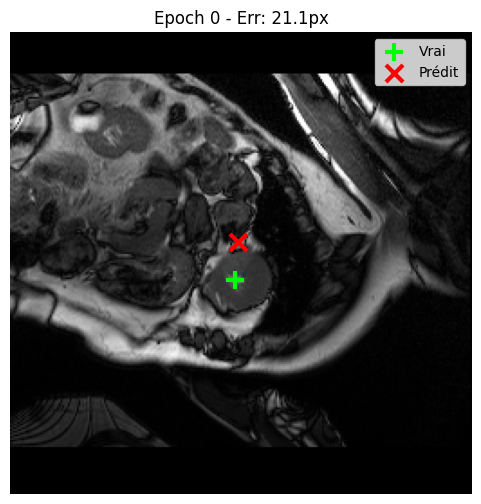

Epoch 0 [Train][DONE]                              
Epoch 0 | Train Loss: 0.00730 | Val Loss: 0.00905 | Time: 15.1s
✅ Amélioration ! (Ancien Best: inf -> Nouveau: 0.00905)
   -> Modèle sauvegardé sous : ./Results/Models/best_heart_locator.pt
Epoch 1 [Train][DONE]                              
Epoch 1 | Train Loss: 0.00322 | Val Loss: 0.00705 | Time: 15.8s
✅ Amélioration ! (Ancien Best: 0.00905 -> Nouveau: 0.00705)
   -> Modèle sauvegardé sous : ./Results/Models/best_heart_locator.pt
Epoch 2 [Train][DONE]                              
Epoch 2 | Train Loss: 0.00283 | Val Loss: 0.00626 | Time: 15.9s
✅ Amélioration ! (Ancien Best: 0.00705 -> Nouveau: 0.00626)
   -> Modèle sauvegardé sous : ./Results/Models/best_heart_locator.pt
Epoch 3 [Train][=>             ] 11.1%Loss=0.00246

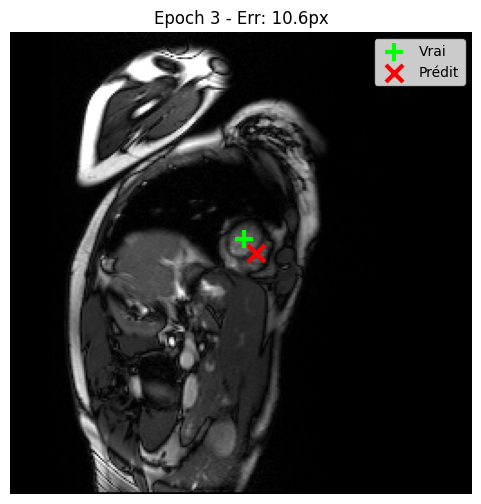

Epoch 3 [Train][DONE]                              
Epoch 3 | Train Loss: 0.00262 | Val Loss: 0.00665 | Time: 16.4s
   (Pas d'amélioration, Best reste 0.00626 à l'epoch 2)
Epoch 4 [Train][DONE]                              
Epoch 4 | Train Loss: 0.00206 | Val Loss: 0.00591 | Time: 15.9s
✅ Amélioration ! (Ancien Best: 0.00626 -> Nouveau: 0.00591)
   -> Modèle sauvegardé sous : ./Results/Models/best_heart_locator.pt
Epoch 5 [Train][DONE]                              
Epoch 5 | Train Loss: 0.00187 | Val Loss: 0.00787 | Time: 17.6s
   (Pas d'amélioration, Best reste 0.00591 à l'epoch 4)
Epoch 6 [Train][=>             ] 11.1%Loss=0.00190

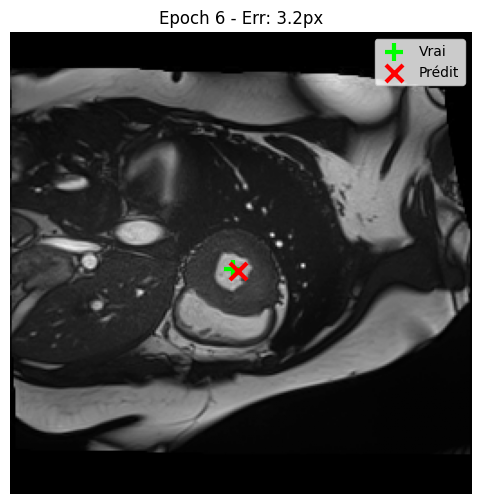

Epoch 6 [Train][DONE]                              
Epoch 6 | Train Loss: 0.00219 | Val Loss: 0.00676 | Time: 17.1s
   (Pas d'amélioration, Best reste 0.00591 à l'epoch 4)
Epoch 7 [Train][DONE]                              
Epoch 7 | Train Loss: 0.00169 | Val Loss: 0.00645 | Time: 17.0s
   (Pas d'amélioration, Best reste 0.00591 à l'epoch 4)
Epoch 8 [Train][DONE]                              
Epoch 8 | Train Loss: 0.00159 | Val Loss: 0.00489 | Time: 17.9s
✅ Amélioration ! (Ancien Best: 0.00591 -> Nouveau: 0.00489)
   -> Modèle sauvegardé sous : ./Results/Models/best_heart_locator.pt
Epoch 9 [Train][=>             ] 11.1%Loss=0.00159

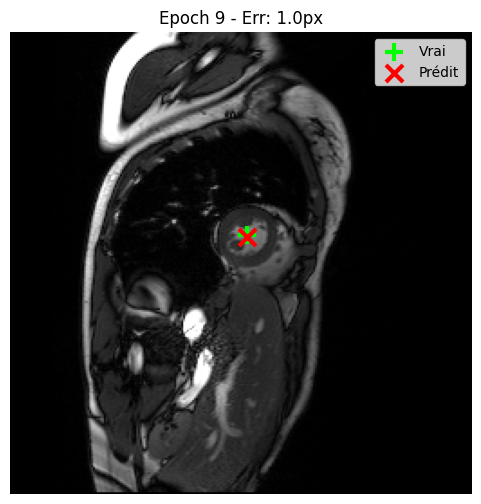

Epoch 9 [Train][DONE]                              
Epoch 9 | Train Loss: 0.00168 | Val Loss: 0.00627 | Time: 17.4s
   (Pas d'amélioration, Best reste 0.00489 à l'epoch 8)
Epoch 10 [Train][DONE]                              
Epoch 10 | Train Loss: 0.00167 | Val Loss: 0.00570 | Time: 16.9s
   (Pas d'amélioration, Best reste 0.00489 à l'epoch 8)
Epoch 11 [Train][DONE]                              
Epoch 11 | Train Loss: 0.00154 | Val Loss: 0.00634 | Time: 16.5s
   (Pas d'amélioration, Best reste 0.00489 à l'epoch 8)
Epoch 12 [Train][=>             ] 11.1%Loss=0.00245

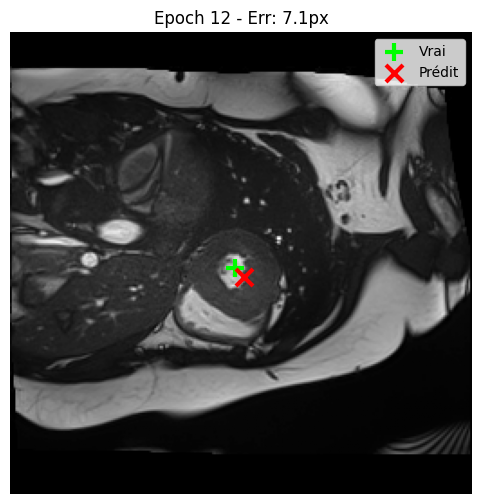

Epoch 12 [Train][DONE]                              
Epoch 12 | Train Loss: 0.00136 | Val Loss: 0.00570 | Time: 16.7s
   (Pas d'amélioration, Best reste 0.00489 à l'epoch 8)
Epoch 13 [Train][DONE]                              
Epoch 13 | Train Loss: 0.00142 | Val Loss: 0.00652 | Time: 16.0s
   (Pas d'amélioration, Best reste 0.00489 à l'epoch 8)
Epoch 14 [Train][DONE]                              
Epoch 14 | Train Loss: 0.00144 | Val Loss: 0.00518 | Time: 16.0s
   (Pas d'amélioration, Best reste 0.00489 à l'epoch 8)
Epoch 15 [Train][=>             ] 11.1%Loss=0.00072

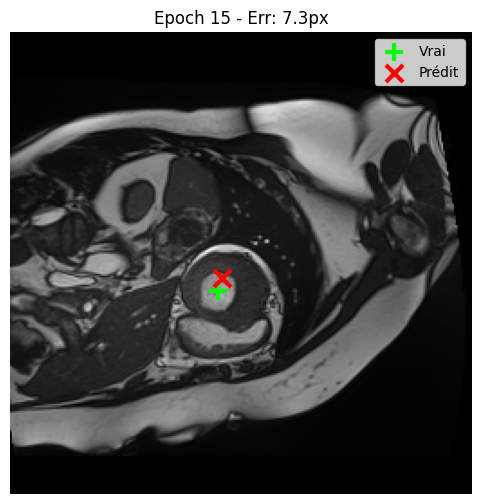

Epoch 15 [Train][DONE]                              
Epoch 15 | Train Loss: 0.00123 | Val Loss: 0.00614 | Time: 16.6s
   (Pas d'amélioration, Best reste 0.00489 à l'epoch 8)
Epoch 16 [Train][DONE]                              
Epoch 16 | Train Loss: 0.00126 | Val Loss: 0.00606 | Time: 16.9s
   (Pas d'amélioration, Best reste 0.00489 à l'epoch 8)
Epoch 17 [Train][DONE]                              
Epoch 17 | Train Loss: 0.00123 | Val Loss: 0.00551 | Time: 18.5s
   (Pas d'amélioration, Best reste 0.00489 à l'epoch 8)
Epoch 18 [Train][=>             ] 11.1%Loss=0.00138

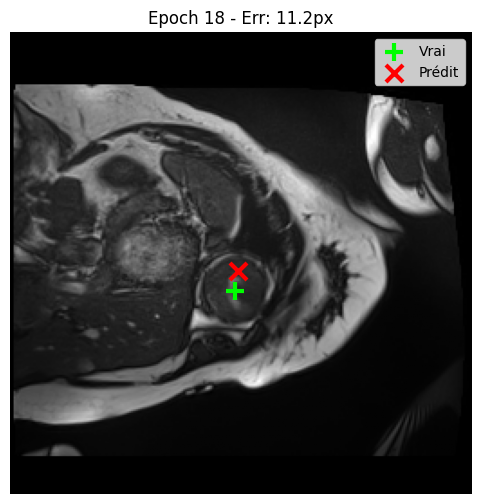

Epoch 18 [Train][DONE]                              
Epoch 18 | Train Loss: 0.00138 | Val Loss: 0.00631 | Time: 18.1s
   (Pas d'amélioration, Best reste 0.00489 à l'epoch 8)
Epoch 19 [Train][DONE]                              
Epoch 19 | Train Loss: 0.00127 | Val Loss: 0.00621 | Time: 17.5s
   (Pas d'amélioration, Best reste 0.00489 à l'epoch 8)
Epoch 20 [Train][DONE]                              
Epoch 20 | Train Loss: 0.00113 | Val Loss: 0.00625 | Time: 17.6s
   (Pas d'amélioration, Best reste 0.00489 à l'epoch 8)
Epoch 21 [Train][=>             ] 11.1%Loss=0.00113

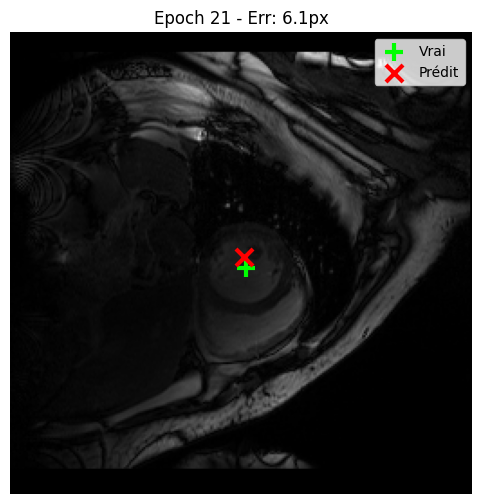

Epoch 21 [Train][DONE]                              
Epoch 21 | Train Loss: 0.00126 | Val Loss: 0.00571 | Time: 18.6s
   (Pas d'amélioration, Best reste 0.00489 à l'epoch 8)
Epoch 22 [Train][DONE]                              
Epoch 22 | Train Loss: 0.00116 | Val Loss: 0.00523 | Time: 18.9s
   (Pas d'amélioration, Best reste 0.00489 à l'epoch 8)
Epoch 23 [Train][DONE]                              
Epoch 23 | Train Loss: 0.00113 | Val Loss: 0.00718 | Time: 19.9s
   (Pas d'amélioration, Best reste 0.00489 à l'epoch 8)
Epoch 24 [Train][=>             ] 11.1%Loss=0.00056

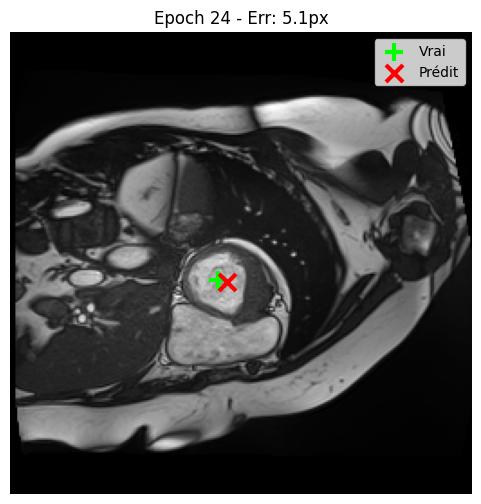

Epoch 24 [Train][DONE]                              
Epoch 24 | Train Loss: 0.00119 | Val Loss: 0.00646 | Time: 17.8s
   (Pas d'amélioration, Best reste 0.00489 à l'epoch 8)

FIN. Le meilleur modèle est celui de l'epoch 8 avec Val Loss = 0.00489


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from scipy.ndimage import center_of_mass

import medicalDataLoader
from progressBar import printProgressBar
from utils import getTargetSegmentation

BATCH_SIZE = 16
LR = 0.0005          
EPOCHS = 25          
ROOT_DIR = './Data/'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SAVE_PATH = './Results/Models/best_heart_locator.pt' 
IMG_SIZE = 256

def visualize_center_prediction(image_tensor, predicted_offset, true_offset, epoch, img_size=IMG_SIZE):
    """
    Affiche une comparaison visuelle entre le centre réel et celui prédit

    Args:
        image_tensor (torch.Tensor): L'image d'entrée 
        predicted_offset (torch.Tensor): Coordonnées prédites normalisées 
        true_offset (torch.Tensor): Coordonnées réelles normalisées
        epoch (int): Epoque actuelle
        img_size (int): Taille de l'image en pixels 

    Returns:
        None: Affiche un plot matplotlib.
    """
    if torch.isnan(predicted_offset).any(): 
        return
    
    img = image_tensor.cpu().numpy().squeeze()
    
    # récupération des valeurs scalaires
    pred_y_norm, pred_x_norm = predicted_offset
    true_y_norm, true_x_norm = true_offset.cpu().numpy()
    
    #passage de [-1;1] à [0,256]
    py_px = int(pred_y_norm.item() * (img_size / 2) + (img_size / 2))
    px_px = int(pred_x_norm.item() * (img_size / 2) + (img_size / 2))
    ty_px = int(true_y_norm * (img_size / 2) + (img_size / 2))
    tx_px = int(true_x_norm * (img_size / 2) + (img_size / 2))

    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap='gray')
    plt.scatter(tx_px, ty_px, c='lime', s=150, marker='+', linewidths=3, label='Vrai')
    plt.scatter(px_px, py_px, c='red', s=150, marker='x', linewidths=3, label='Prédit')
    
    #calcul de l'erreur en pixel, distance euclidienne
    error = np.sqrt((px_px - tx_px)**2 + (py_px - ty_px)**2)
    plt.title(f"Epoch {epoch} - Err: {error:.1f}px")
    plt.axis('off')
    plt.legend()
    plt.show()
    plt.close()


class ComplexHeartLocator(nn.Module):
    """
    CNN pour la régression
    """
    def __init__(self):
        super(ComplexHeartLocator, self).__init__()
        
        # extraction de features bas niveau
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32), # stabilise l'apprentissage
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2) # divise par 2 la taille, 128x128
        )
        
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2) # taille 64x64
        )
        
        
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), # Double conv pour plus de profondeur sans diviser la taille
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2) # 32x32
        )
        
        self.block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2) # 16x16
        )

        self.block5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1)) # Robuste pour n'immporte quelle taille d'entrée
        )
        
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5), # évite l'overfitting
            nn.Linear(128, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 2) #sortie finale : 2 neurones (y, x)
        )
        
        # Initialisation des poids pour éviter les NaNs au départ
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        return self.regressor(x)



def get_lv_centers(labels_batch, img_size=IMG_SIZE):
    """
    Calcule le centre de masse du VG et normalise les coordonnées.

    Args:
        labels_batch (torch.Tensor): Masques de segmentation bruts 
        img_size (int): Taille de l'image 

    Returns:
        torch.Tensor: Coordonnées normalisées entre -1.0 et 1.0.
    
    """
    batch_centers = []
    labels_np = getTargetSegmentation(labels_batch).cpu().numpy()
    
    for i in range(labels_np.shape[0]):
        # isoler le masque binaire du VG (classe3)
        mask_lv = (labels_np[i] == 3).astype(int)
        if mask_lv.sum() > 0:
            #calcul du barycentre
            y, x = center_of_mass(mask_lv)
            #normalisation
            y_norm = (y - (img_size / 2)) / (img_size / 2)
            x_norm = (x - (img_size / 2)) / (img_size / 2)
        else:
            y_norm, x_norm = 0.0, 0.0
        batch_centers.append([y_norm, x_norm])
            
    return torch.tensor(batch_centers, dtype=torch.float32)


def train_locator():
    """
    Fonction principale d'entraînement
    """
    print("Entraînement du ComplexHeartLocator ")
    
    #tensorisation
    transform = transforms.Compose([transforms.ToTensor()])
    mask_transform = transforms.Compose([transforms.ToTensor()])
    
    # apprentissage d'abord sur les données de train sans augmentation
    train_set = medicalDataLoader.MedicalImageDataset('train', ROOT_DIR, transform=transform, mask_transform=mask_transform, augment=False)
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

    val_set = medicalDataLoader.MedicalImageDataset('val', ROOT_DIR, transform=transform, mask_transform=mask_transform, augment=False)
    val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    
    model = ComplexHeartLocator().to(DEVICE)
    # Adam avec régularisation L2 pour éviter l'overfitting 
    optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5) 
    # Loss MSE : Standard pour la régression
    criterion = nn.MSELoss() 
    
    if not os.path.exists(os.path.dirname(SAVE_PATH)):
        os.makedirs(os.path.dirname(SAVE_PATH))

    best_val_loss = float('inf')#on commence à inf pour etre sur d'améliorer
    best_epoch = -1

    for epoch in range(EPOCHS):
        model.train() #Active Dropout et BatchNorm
        train_loss = 0
        count_train = 0
        start_time = time.time()
        
        for i, data in enumerate(train_loader):
            images, labels, _ = data
            targets = get_lv_centers(labels).to(DEVICE)
            images = images.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(images)
            
            if torch.isnan(outputs).any():
                print(f"Arrêt car NaNs détectés (Epoch {epoch})")
                return

            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            count_train += 1
            
            printProgressBar(i + 1, len(train_loader), prefix=f"Epoch {epoch} [Train]", suffix=f"Loss={loss.item():.5f}", length=15)
            
            if i == 0 and epoch % 3 == 0: 
                visualize_center_prediction(images[0], outputs[0].detach(), targets[0].detach(), epoch)

        avg_train_loss = train_loss / max(1, count_train)

        model.eval()
        val_loss = 0
        count_val = 0
        
        with torch.no_grad():#pas de gradient donc meilleure memoire
            for i, data in enumerate(val_loader):
                images, labels, _ = data
                targets = get_lv_centers(labels).to(DEVICE)
                images = images.to(DEVICE)
                
                outputs = model(images)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                count_val += 1
        
        avg_val_loss = val_loss / max(1, count_val)
        
        duration = time.time() - start_time
        print(f"Epoch {epoch} | Train Loss: {avg_train_loss:.5f} | Val Loss: {avg_val_loss:.5f} | Time: {duration:.1f}s")

        if avg_val_loss < best_val_loss:
            print(f"Amélioration (Ancien meilleur: {best_val_loss:.5f} -> Nouveau: {avg_val_loss:.5f})")
            best_val_loss = avg_val_loss
            best_epoch = epoch
            torch.save(model.state_dict(), SAVE_PATH)
            print(f"Modèle sauvegardé {SAVE_PATH}")
        else:
            print(f"(Pas d'amélioration, le meilleur reste {best_val_loss:.5f} à l'epoch {best_epoch})")

    print(f"\nFIN. Le meilleur modèle est celui de l'epoch {best_epoch} avec Val Loss = {best_val_loss:.5f}")

if __name__ == "__main__":
    train_locator()

In [ ]:
def shift_batch_on_gpu(guide_tensor, offsets_norm, H, W):
    """
    Déplace dynamiquement le masque guide  pour l'aligner avec la position prédite
    
    Args :
        guide_tensor (torch.Tensor) : masque guide de base sur GPU
        offsets_norm (torch.Tensor) :prédictions y, x normalisées entre -1 et 1
        H (int): Hauteur de l'image 
        W (int): Largeur de l'image

    Return : 
        torch.Tensor: batch de guides alignés
    """

    #recuperation des dim
    B = offsets_norm.shape[0]
    C = guide_tensor.shape[0]
    

    #copie physique en mémoire
    guides_batch = guide_tensor.unsqueeze(0).expand(B, -1, -1, -1).clone()
    
    # Convertir les offsets normalisés en pixels 
    shift_y = (offsets_norm[:, 0] * (H / 2)).long()
    shift_x = (offsets_norm[:, 1] * (W / 2)).long()
    
    for b in range(B):
        dy = shift_y[b].item()
        dx = shift_x[b].item()
        
        guides_batch[b] = torch.roll(guides_batch[b], shifts=(dy, dx), dims=(1, 2))

    return guides_batch